In [1]:
# import the basic libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import warnings
warnings.filterwarnings("ignore")

In [3]:
fake_news = pd.read_csv("/content/news.csv")
fake_news.head()

,Unnamed: 0,title,text,label
0,8476,You Can Smell Hillary’s Fear,"Daniel Greenfield, a Shillman Journalism Fello...",FAKE
1,10294,Watch The Exact Moment Paul Ryan Committed Pol...,Google Pinterest Digg Linkedin Reddit Stumbleu...,FAKE
2,3608,Kerry to go to Paris in gesture of sympathy,U.S. Secretary of State John F. Kerry said Mon...,REAL
3,10142,Bernie supporters on Twitter erupt in anger ag...,"— Kaydee King (@KaydeeKing) November 9, 2016 T...",FAKE
4,875,The Battle of New York: Why This Primary Matters,It's primary day in New York and front-runners...,REAL


In [5]:
!pip install tensorflow

In [6]:
import re
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics import accuracy_score

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Embedding, LSTM, SpatialDropout1D, Reshape
from tensorflow.keras.layers import Conv1D, GlobalMaxPool1D
from tensorflow.keras.preprocessing.sequence import pad_sequences

In [7]:
# Drop the un_unvanted collumns in fake_news data set
fake_news.drop(["Unnamed: 0"], axis=1, inplace=True)

In [8]:
# Converted the label column as Fake: 0 and REAL: 1
fake_news['label'] = fake_news['label'].map({'REAL': 1, 'FAKE': 0})
fake_news.head(5)

,title,text,label
0,You Can Smell Hillary’s Fear,"Daniel Greenfield, a Shillman Journalism Fello...",0
1,Watch The Exact Moment Paul Ryan Committed Pol...,Google Pinterest Digg Linkedin Reddit Stumbleu...,0
2,Kerry to go to Paris in gesture of sympathy,U.S. Secretary of State John F. Kerry said Mon...,1
3,Bernie supporters on Twitter erupt in anger ag...,"— Kaydee King (@KaydeeKing) November 9, 2016 T...",0
4,The Battle of New York: Why This Primary Matters,It's primary day in New York and front-runners...,1


In [9]:
def plot_training_history(history):
    plt.figure(figsize=(12, 4))

    plt.subplot(1, 2, 1)
    plt.plot(history.history['accuracy'], label='Training', marker='o')
    plt.plot(history.history['val_accuracy'], label='Validation', marker='o')
    plt.title('Model Accuracy')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.legend()

    plt.subplot(1, 2, 2)
    plt.plot(history.history['loss'], label='Training', marker='o')
    plt.plot(history.history['val_loss'], label='Validation', marker='o')
    plt.title('Model Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()

    plt.tight_layout()
    plt.show()

In [10]:
def preproccesing(title, text):
    combined_text = title + " " + text
    combined_text = combined_text.strip()

    return combined_text
fake_news["combined_text"] = fake_news.apply(lambda row: preproccesing(row["title"], row["text"]), axis = 1)
fake_news.head()

,title,text,label,combined_text
0,You Can Smell Hillary’s Fear,"Daniel Greenfield, a Shillman Journalism Fello...",0,You Can Smell Hillary’s Fear Daniel Greenfield...
1,Watch The Exact Moment Paul Ryan Committed Pol...,Google Pinterest Digg Linkedin Reddit Stumbleu...,0,Watch The Exact Moment Paul Ryan Committed Pol...
2,Kerry to go to Paris in gesture of sympathy,U.S. Secretary of State John F. Kerry said Mon...,1,Kerry to go to Paris in gesture of sympathy U....
3,Bernie supporters on Twitter erupt in anger ag...,"— Kaydee King (@KaydeeKing) November 9, 2016 T...",0,Bernie supporters on Twitter erupt in anger ag...
4,The Battle of New York: Why This Primary Matters,It's primary day in New York and front-runners...,1,The Battle of New York: Why This Primary Matte...


In [31]:
!pip install tensorflow-text

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 5.2/5.2 MB 44.6 MB/s eta 0:00:00


In [33]:
import tensorflow as tf
import tensorflow_text as text

In [42]:
# Split the dataset
x_train, x_test, y_train, y_test = train_test_split(fake_news['combined_text'],
                                                    fake_news['label'], test_size=0.2,
                                                    random_state=42)

# Initialize TfidfVectorizer
vectorizer = TfidfVectorizer(max_features=10000)
x_train_tfidf = vectorizer.fit_transform(x_train)
x_test_tfidf = vectorizer.transform(x_test)

# Convert to dense array for deep learning model
x_train_tfidf = x_train_tfidf.toarray()
x_test_tfidf = x_test_tfidf.toarray()

In [43]:
from keras.layers import Conv1D, GlobalMaxPooling1D

model = Sequential()

# Input layer (you might want to use an Embedding layer here if you switch to word embeddings)
model.add(Dense(64, input_shape=(10000,), activation='relu'))
model.add(Reshape((64, -1)))

# Convolutional Layer
model.add(Conv1D(filters=128, kernel_size=5, activation='relu'))
model.add(GlobalMaxPooling1D())

# Dense Layer
model.add(Dense(32, activation='relu'))

# Output layer
model.add(Dense(1, activation='sigmoid'))

# Compile the model
model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])

In [44]:
model.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_6 (Dense)             (None, 64)                640064    
                                                                 
 reshape_2 (Reshape)         (None, 64, 1)             0         
                                                                 
 conv1d_2 (Conv1D)           (None, 60, 128)           768       
                                                                 
 global_max_pooling1d_2 (Gl  (None, 128)               0         
 obalMaxPooling1D)                                               
                                                                 
 dense_7 (Dense)             (None, 32)                4128      
                                                                 
 dense_8 (Dense)             (None, 1)                 33        
                                                      

In [45]:
history = model.fit(x_train_tfidf, y_train, validation_data=(x_test_tfidf, y_test), epochs=10, batch_size=64)

Epoch 1/10
44/44 [==============================] - 2s 27ms/step - loss: 0.6770 - accuracy: 0.5595 - val_loss: 0.6242 - val_accuracy: 0.6254
Epoch 2/10
44/44 [==============================] - 1s 19ms/step - loss: 0.5193 - accuracy: 0.8164 - val_loss: 0.3972 - val_accuracy: 0.8818
Epoch 3/10
44/44 [==============================] - 1s 20ms/step - loss: 0.2670 - accuracy: 0.9610 - val_loss: 0.2247 - val_accuracy: 0.9352
Epoch 4/10
44/44 [==============================] - 1s 20ms/step - loss: 0.0797 - accuracy: 0.9895 - val_loss: 0.1702 - val_accuracy: 0.9452
Epoch 5/10
44/44 [==============================] - 1s 18ms/step - loss: 0.0195 - accuracy: 0.9978 - val_loss: 0.1672 - val_accuracy: 0.9424
Epoch 6/10
44/44 [==============================] - 1s 20ms/step - loss: 0.0073 - accuracy: 0.9993 - val_loss: 0.1694 - val_accuracy: 0.9438
Epoch 7/10
44/44 [==============================] - 1s 29ms/step - loss: 0.0038 - accuracy: 0.9996 - val_loss: 0.1750 - val_accuracy: 0.9438
Epoch 8/10
44

In [46]:
# CNN with 10epochs
loss, accuracy = model.evaluate(x_test_tfidf, y_test, verbose = 0)
print(f"Accuracy: {round(accuracy*100, 2)}%")

Accuracy: 94.52%


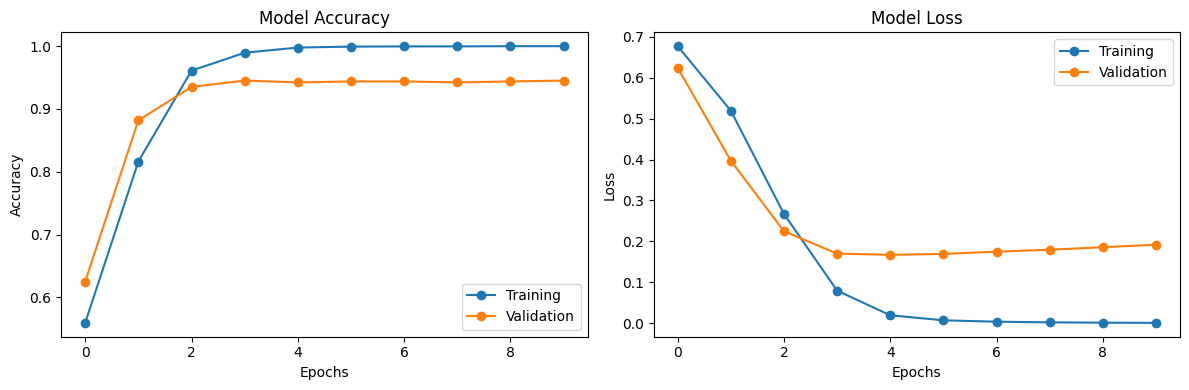

In [47]:
plot_training_history(history)

In [48]:
# Separate title and text
def clean_text(text):
  text = text.strip()
  text = text.lower()
  text = re.sub(r'[^a-zA-Z0-9\s]', '', text)

  return text

In [51]:
# Preprocesing the title and text separatly
fake_news["Clean_Text"] = fake_news["text"].apply(clean_text)
fake_news["Clean_Title"] = fake_news["title"].apply(clean_text)

# Split the dataset into train and test
x_train_texts, x_test_texts, y_train, y_test = train_test_split(
    fake_news['Clean_Text'], fake_news['label'], test_size=0.2, random_state=42)

x_train_titles, x_test_titles, y_train, y_test = train_test_split(
  fake_news['Clean_Title'], fake_news['label'], test_size=0.2, random_state=42)

# Vectorize the title and text (i.e; You might want fewer features for titles & text)
title_vectorizer = TfidfVectorizer(max_features=5000)
text_vectorizer = TfidfVectorizer(max_features=10000)

x_train_titles = title_vectorizer.fit_transform(x_train_titles).toarray()
x_train_texts = text_vectorizer.fit_transform(x_train_texts).toarray()

x_test_titles = title_vectorizer.transform(x_test_titles).toarray()
x_test_texts = text_vectorizer.transform(x_test_texts).toarray()

In [50]:
from keras.layers import Input, Dense, concatenate
from keras.models import Model

# Title branch
title_input = Input(shape=(5000,), name='title_input')
title_branch = Dense(64, activation='relu')(title_input)
title_branch = Reshape((64, -1))(title_branch)
title_branch = Conv1D(128, 5, activation='relu')(title_branch)
title_branch = GlobalMaxPooling1D()(title_branch)

# Text branch
text_input = Input(shape=(10000,), name='text_input')
text_branch = Dense(64, activation='relu')(text_input)
text_branch = Reshape((64, -1))(text_branch)
text_branch = Conv1D(128, 5, activation='relu')(text_branch)
text_branch = GlobalMaxPooling1D()(text_branch)

# Combine branches
combined = concatenate([title_branch, text_branch])

# Add final layers
combined = Dense(64, activation='relu')(combined)
output = Dense(1, activation='sigmoid')(combined)

model = Model(inputs=[title_input, text_input], outputs=output)

In [52]:
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

history = model.fit([x_train_titles, x_train_texts], y_train,
            validation_data=([x_test_titles, x_test_texts], y_test),
            epochs=10, batch_size=32)

Epoch 1/10
87/87 [==============================] - 4s 25ms/step - loss: 0.6328 - accuracy: 0.6360 - val_loss: 0.4277 - val_accuracy: 0.8732
Epoch 2/10
87/87 [==============================] - 2s 18ms/step - loss: 0.2178 - accuracy: 0.9394 - val_loss: 0.1765 - val_accuracy: 0.9280
Epoch 3/10
87/87 [==============================] - 2s 18ms/step - loss: 0.0377 - accuracy: 0.9899 - val_loss: 0.1683 - val_accuracy: 0.9323
Epoch 4/10
87/87 [==============================] - 2s 28ms/step - loss: 0.0066 - accuracy: 0.9986 - val_loss: 0.1857 - val_accuracy: 0.9352
Epoch 5/10
87/87 [==============================] - 2s 21ms/step - loss: 0.0021 - accuracy: 1.0000 - val_loss: 0.1877 - val_accuracy: 0.9308
Epoch 6/10
87/87 [==============================] - 2s 19ms/step - loss: 0.0011 - accuracy: 1.0000 - val_loss: 0.1920 - val_accuracy: 0.9352
Epoch 7/10
87/87 [==============================] - 2s 20ms/step - loss: 7.0169e-04 - accuracy: 1.0000 - val_loss: 0.1971 - val_accuracy: 0.9352
Epoch 8/1

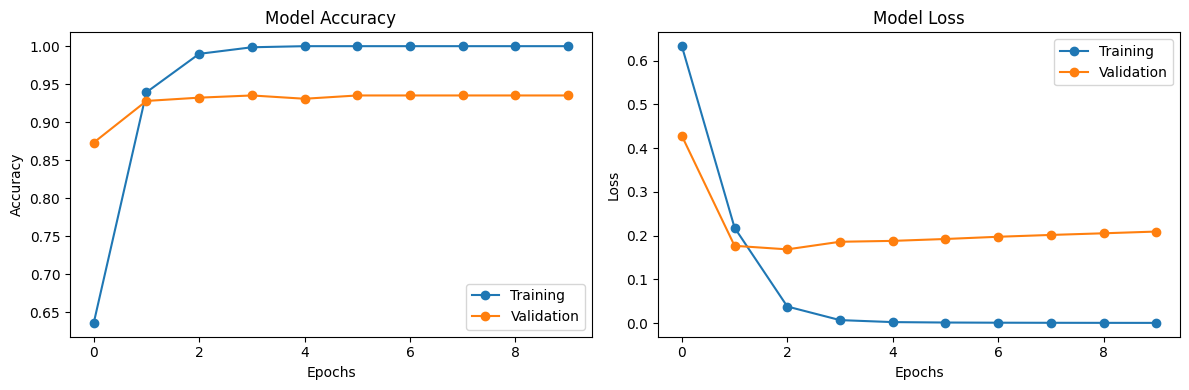

In [53]:
plot_training_history(history)

In [54]:
loss, accuracy = model.evaluate([x_test_titles, x_test_texts], y_test, verbose=0)
print(f'Accuracy: {round(accuracy*100,2)}%')

Accuracy: 93.52%


In [55]:
# Save the model
model.save('fakenews_cnn_model.h5')